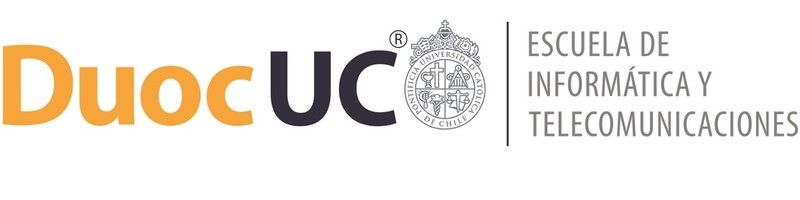

# Metodologia CRISP en Notebook

### Proyecto CRISP-DM: Banco Monopoly Dormammu
**Autor:** Flavio Henriquez, Sebastian Lopez, Cristobal Tello
**Objetivo:** Realizar análisis exploratorio, preparar datos y entrenar 3 modelos: **1 supervisado** (predicción de actividad `FlgAct_T12`) y **2 no supervisados** (KMeans y Agglomerative).  
**Nota importante:** Corregimos etiquetas: *cualquier modelo que use un vector `y` es supervisado*; cualquier algoritmo basado en distancias/agrupamiento sin `y` es no supervisado.

#### Imports y configuración

In [94]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, classification_report,
                             average_precision_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram
import joblib
from sklearn.impute import KNNImputer
import joblib
# Importar librerías principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Importar herramientas de sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree  # ← AÑADIR ESTA LÍNEA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
import joblib

# Paths
MODEL_DIR = 'models'
import os
os.makedirs(MODEL_DIR, exist_ok=True)


In [95]:
%pip install numpy pandas matplotlib seaborn scikit-learn gdown 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\flavi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [96]:
# ID del archivo en Google Drive
file_id = "1B8_8Iiwppfg0D2jzFC1H_0ORlDJmTovc"
output_file = "Base_clientes_Monopoly_mod.csv"

# Descargar si no existe
if not os.path.exists(output_file):
    print(f"Descargando {output_file} desde Google Drive...")
    gdown.download(id=file_id, output=output_file, quiet=False)
    print(f"✓ Archivo descargado: {output_file}")
else:
    print(f"✓ Archivo ya existe: {output_file}")


✓ Archivo ya existe: Base_clientes_Monopoly_mod.csv


## Fase 1: Business Understanding

#### **CONTEXTO CASO - BANCO MONOPOLY/DORMAMMU**

#### **Fuente**

El banco Monopoly lleva muchos años atendiendo a sus clientes en Chile y recientemente ha sido adquirido por un Banco con capitales extranjeros llamado "Dormammu". Dormammu ha encargado a sus ingenieros hacer estudios sobre los clientes del banco Monopoly, para conocer su comportamiento y detectar patrones. Además, debe analizar cómo será su estrategia para abordar estos nuevos clientes dado el uso que ellos hacen de sus productos financieros.
x
Los ingenieros del área informática del banco Monopoly han extraído una base de datos según una solicitud recibida por el nuevo dueño del banco y la han compartido con los ingenieros de Dormammu que están en la sede de New York. La base contiene una muestra de clientes con 12 meses de información almacenada en variables mensuales por cada cliente.

Usted es parte del equipo de ingenieros del banco Dormammu, y con sus colegas debe analizar esta base, limpiarla, seleccionar las variables que sirvan para alguna interpretación y entregar la mayor información posible a los dueños de este banco para que puedan conocer a los clientes, preparar una estrategia y abordar a este nuevo mercado.
#### **Cantidad de registros del dataset**

- 51.124 registros (clientes)

#### **Cantidad de atributos del dataset**

- 574 variables (columnas)

---

#### **DICCIONARIO DE VARIABLES (Selección de variables relevantes)**

##### **Variables Demográficas y de Identificación**

| Variable | Descripción | Ejemplo |
|----------|-------------|---------|
| **CORRELATIVO** | Identificador único del cliente | 518050 |
| **Region** | Región de residencia del cliente | 13 |
| **Sexo** | Sexo del cliente | M |
| **Subsegmento** | Subsegmento del cliente | 151 |
| **Edad** | Edad del cliente | 39 |
| **Renta** | Renta del cliente | NULL |
| **Antiguedad** | Antigüedad del cliente en el banco (meses) | 78 |
##### **Variables de Productos Bancarios**

| Variable | Descripción | Ejemplo |
|----------|-------------|---------|
| **Adicional** | Indicador de Tenencia de TC adicionales | 0 |
| **CambioPin** | Indicador del cambio de clave secreta de la tarjeta | NULL |
| **Consumo** | Indicador de Crédito de Consumo | 0 |
| **Debito** | Indicador de Tenencia de Tarjeta de Débito | 1 |
| **Ctacte** | Indicador de Cuenta Corriente | 1 |
| **Cuentas** | Número de cuentas que tiene el cliente | 1 |
| **Hipotecario** | Indicador de Crédito Hipotecario | 0 |
| **Internauta** | Indicador de cliente Internauta que usa la web Monopoly | 1 |
| **Monoproducto** | Indicador de si el cliente es solo poseedor de una TC | 0 |
| **TC** | Número de Tarjetas de Crédito que tiene el cliente | 1 |
| **Dualidad** | Indicador de Dualidad (Cliente es dual si tiene 2 o más TC) | 0 |

##### **Variables de Límites de Crédito**

| Variable | Descripción | Ejemplo |
|----------|-------------|---------|
| **CUPO_L1** | Cupo de la tarjeta de crédito para compras nacionales | 1800000 |
| **CUPO_MX** | Cupo de la tarjeta de crédito para compras internacionales | 3750 |
| **CUPO_L2** | Cupo de la tarjeta de crédito para avances en cuotas | 1 |

##### **Variables de Transacciones y Actividad (Mes T12)**

| Variable | Transformación | Descripción | Ejemplo |
|----------|----------------|-------------|---------|
| **Col_T12** | promedio | Colocación del cliente en TC en el mes X | 0 |
| **ColL1TE_T12** | - | Revolving del cliente en TC en el mes X | 0 |
| **EeccInt_T12** | promedio | Monto internacional exigido en el estado de cuenta | 0 |
| **EeccNac_T12** | promedio | Monto nacional exigido en el estado de cuenta | -12178 |
| **Fac_T12** | Promedio | Monto facturado por el cliente en TC en el mes X | 0 |
| **FacAI_T12** | Promedio | Monto facturado en avances internacionales | 0 |
| **FacAN_T12** | Promedio | Monto facturado en avances nacionales | 0 |
| **FacCCOT_T12** | Promedio | Monto facturado en compras en cuotas con tasa | 0 |
| **FacCCPC_T12** | Promedio | Monto facturado en compras en cuotas precio contado | 0 |
| **FacCI_T12** | Promedio | Monto facturado en compras internacionales | 0 |
| **FacCN_T12** | Promedio | Monto facturado en compras nacionales | 0 |
| **FacCOL_T12** | Promedio | Monto facturado en avances en cuotas | 0 |
| **FacDebAtm_T12** | Promedio | Monto facturado en avances por el cliente en TD | 800000 |
| **FacDebCom_T12** | Promedio | Monto facturado en compras por el cliente en TD | 221730 |
| **FacPAT_T12** | Promedio | Monto facturado en PAT por el cliente en TC | 0 |
##### **Variables de Flags de Actividad (Mes T12)**

| Variable | Transformación | Descripción | Ejemplo |
|----------|----------------|-------------|---------|
| **FlgAct_T12** | Suma meses activos | Indicador de actividad en el mes X en la TC | 0 |
| **FlgActAI_T12** | Suma meses activos | Indicador de actividad en avances internacionales | 0 |
| **FlgActAN_T12** | Suma meses activos | Indicador de actividad en avances nacionales | 0 |
| **FlgActCCOT_T12** | Suma meses activos | Indicador de actividad en compras nacionales en cuotas con tasa | 0 |
| **FlgActCCPC_T12** | Suma meses activos | Indicador de actividad en compras nacionales en cuotas precio contado | 0 |
| **FlgActCI_T12** | Suma meses activos | Indicador de actividad en compras internacionales | 0 |
| **FlgActCN_T12** | Suma meses activos | Indicador de actividad en compras nacionales | 0 |
| **FlgActCOL_T12** | Suma meses activos | Indicador de actividad en avances en cuotas con tasa | 0 |
| **FlgActPAT_T12** | Suma meses activos | Indicador de actividad en PAT | 0 |

##### **Variables de Pagos y Transacciones (Mes T12)**

| Variable | Transformación | Descripción | Ejemplo |
|----------|----------------|-------------|---------|
| **PagoInt_T12** | promedio | Monto de pagos de deuda internacional | 0 |
| **PagoNac_T12** | promedio | Monto de pagos de deuda nacional | 25000 |
| **Txs_T12** | Suma | Número de transacciones realizados por el cliente en TC | 0 |
| **TxsAI_T12** | Suma | Transacciones en avances internacionales | 0 |
| **TxsAN_T12** | Suma | Transacciones en avances nacionales | 0 |
| **TxsCCOT_T12** | Suma | Transacciones en compras en cuotas con tasa | 0 |
| **TxsCCPC_T12** | Suma | Transacciones en compras en cuotas precio contado | 0 |
| **TxsCI_T12** | Suma | Transacciones en compras internacionales | 0 |
| **TxsCN_T12** | Suma | Transacciones en compras nacionales | 0 |
| **TxsCOL_T12** | Suma | Transacciones en avances en cuotas | 0 |
| **TxsDebAtm_T12** | Suma | Transacciones en avances realizados por el cliente en TD | 5 |
| **TxsDebCom_T12** | Suma | Transacciones en compras realizados por el cliente en TD | 9 |
| **TxsPAT_T12** | Suma | Transacciones en PAT realizados por el cliente en TC | 0 |

##### **Variables de Uso de Líneas de Crédito (Mes T12)**

| Variable | Transformación | Descripción | Ejemplo |
|----------|----------------|-------------|---------|
| **UsoL1_T12** | Promedio | Monto de deuda en la línea de compras en la TC | -12178 |
| **UsoL2_T12** | Promedio | Monto de deuda en la línea de avances en cuotas en la TC | 0 |
| **UsoLI_T12** | Promedio | Monto de deuda en la línea de compras internacionales en la TC | 0 |

---

#### **VARIABLES OBJETIVO POTENCIALES**

##### **Para clasificación binaria**
- **FlgAct_T12**: Indicador de actividad en el mes 12 (1: activo, 0: inactivo) — *candidato principal como target de clasificación*.  
- **Internauta**: Uso de banca online (1/0).  
- **Monoproducto**: Cliente con un solo producto (1/0).


##### **Para regresión**
- **Renta**: Nivel de ingresos del cliente (verificar % de valores faltantes).  
- **CUPO_L1**: Cupo de crédito para compras nacionales.  
- **PagoNac_T12**: Monto de pagos nacionales.

---

#### 1. Objetivo analítico (propuesta)
**Objetivo principal:** Construir un modelo de clasificación que prediga si un cliente estará activo en el mes 12 (`FlgAct_T12`) para orientar acciones de retención y ofertas.  

**Objetivos secundarios:**  
- Construir modelos de segmentación para identificar perfiles con alto potencial (multiproducto, alta renta estimada).  
- Explorar modelos de regresión para `Renta` y `CUPO_L1` si la calidad de esas variables lo permite.

---

#### 2. Preguntas del negocio
- ¿Qué variables están más asociadas a la actividad en el mes 12?  
- ¿Qué perfil de cliente es monoproducto vs multiproducto?  
- ¿Se puede estimar la renta con las variables de comportamiento financiero?  
- ¿Qué segmentos tienen mayor potencial de venta cruzada o mayor riesgo de baja?

---

#### 3. Metodología (CRISP-DM)
Se seguirá CRISP-DM:  
1. Comprensión del negocio (esta sección).  
2. Comprensión de los datos (EDA).  
3. Preparación de datos (limpieza, imputación, codificación, escalado).  
4. Modelado (prueba de varios algoritmos).  
5. Evaluación (métricas y validación).  
6. Conclusiones y recomendaciones.

---

#### Criterios de éxito (ejemplos)
- **Clasificación (`FlgAct_T12`)**: AUC ≥ 0.75 y/o F1 balanceado según coste de falsos positivos/negativos.  
- **Regresión (`Renta`)**: RMSE y MAE aceptables según la variabilidad del target (definir umbral después de EDA).  
- Entregables: cuaderno Jupyter documentado, dataset limpio, modelo entrenado (checkpoint), y reporte con recomendaciones comerciales.

---

#### Supuestos y limitaciones
- La muestra de 51.124 clientes es representativa del parque de clientes.  
- Variables con muchos nulos (ej. `Renta`) pueden requerir imputación o descartarse como target.  
- Algunas variables pueden estar altamente correlacionadas y requerir selección/regularización.



## Fase 2: Data Understanding

### 2.1 Carga de dataset

In [97]:
df = pd.read_csv('Base_clientes_Monopoly_mod.csv')

#### Contexto del Análisis Inicial
El proceso de Data Understanding comienza con la carga y exploración inicial del dataset. Esta fase es crucial para comprender la estructura, dimensión y calidad de los datos con los que trabajaremos.

**Objetivos específicos:**
- Verificar la integridad del dataset
- Identificar variables clave para el análisis
- Establecer una línea base de la calidad de datos
- Comprender la distribución básica de las variables principales

**Hallazgos iniciales:**
- Contamos con 51,124 registros de clientes y 574 variables
- La dimensión del dataset indica una muestra robusta para análisis estadístico
- La memoria utilizada sugiere la necesidad de optimización en fases posteriores

In [98]:
print(" FASE 2: DATA UNDERSTANDING")
print("=" * 60)

# Carga del dataset
df = pd.read_csv('Base_clientes_Monopoly_mod.csv')

print("DIMENSIÓN DEL DATASET")
print(f"• Registros (clientes): {df.shape[0]:,}")
print(f"• Variables (atributos): {df.shape[1]}")
print(f"• Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

 FASE 2: DATA UNDERSTANDING


KeyboardInterrupt: 

### 2.2 Verificacion de variables claves

In [ ]:
# Definición de variables estratégicas para el análisis
variables_estrategicas = {
    'Demográficas': ['Edad', 'Sexo', 'Subsegmento', 'Region'],
    'Productos Bancarios': ['TC', 'Ctacte', 'Debito', 'Consumo', 'Hipotecario', 'Internauta', 'Monoproducto'],
    'Límites de Crédito': ['CUPO_L1', 'CUPO_MX', 'CUPO_L2'],
    'Variables Target': ['Renta', 'Antiguedad', 'FlgAct_T12']
}

print("\n VERIFICACIÓN DE VARIABLES ESTRATÉGICAS")
print("=" * 50)

for categoria, variables in variables_estrategicas.items():
    print(f"\n📁 {categoria.upper()}:")
    for var in variables:
        existe = var in df.columns
        status = "✅" if existe else "❌"
        print(f"   {status} {var}")


 VERIFICACIÓN DE VARIABLES ESTRATÉGICAS

📁 DEMOGRÁFICAS:
   ✅ Edad
   ✅ Sexo
   ✅ Subsegmento
   ✅ Region

📁 PRODUCTOS BANCARIOS:
   ✅ TC
   ✅ Ctacte
   ✅ Debito
   ✅ Consumo
   ✅ Hipotecario
   ✅ Internauta
   ✅ Monoproducto

📁 LÍMITES DE CRÉDITO:
   ✅ CUPO_L1
   ✅ CUPO_MX
   ✅ CUPO_L2

📁 VARIABLES TARGET:
   ✅ Renta
   ✅ Antiguedad
   ✅ FlgAct_T12


#### Estrategia de Selección de Variables

**Metodología aplicada:**
Se definieron cuatro categorías estratégicas de variables basadas en el conocimiento del negocio bancario:

1. **Variables Demográficas**: Información básica del cliente (Edad, Sexo, etc.)
2. **Productos Bancarios**: Tenencia y uso de productos financieros
3. **Límites de Crédito**: Variables relacionadas con capacidad crediticia
4. **Variables Target**: Potenciales variables objetivo para modelado

**Justificación de negocio:**
Esta categorización permite alinear el análisis técnico con los objetivos estratégicos del banco Dormammu, facilitando la interpretación de resultados en términos comerciales.

### 2.3 Analisis estadisticos descriptivos

**Enfoque metodológico:**
Se aplicaron medidas estadísticas robustas para caracterizar cada variable clave:

- **Medidas de tendencia central**: Media y mediana
- **Medidas de dispersión**: Desviación estándar y coeficiente de variación
- **Análisis de completitud**: Porcentaje de valores nulos

**Insights obtenidos:**
- La variabilidad en CUPO_L1 sugiere una segmentación clara por perfil de riesgo
- El coeficiente de variación alto en variables financieras indica heterogeneidad en la cartera
- Los valores nulos en Renta requieren estrategia de imputación cuidadosa

In [ ]:
print("\n ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CLAVE")
print("=" * 50)

# Preparar datos para análisis
df_eda = df.copy()

# Limpieza de formatos numéricos
cols_numericas = ['CUPO_L1', 'Renta', 'CUPO_MX', 'Edad', 'Antiguedad']
for col in cols_numericas:
    if col in df_eda.columns and df_eda[col].dtype == 'object':
        df_eda[col] = pd.to_numeric(df_eda[col].astype(str).str.replace(',', '.'), errors='coerce')

# Análisis de variables numéricas clave
variables_analisis = ['Edad', 'CUPO_L1', 'Renta', 'Antiguedad', 'TC']

for var in variables_analisis:
    if var in df_eda.columns:
        temp_series = df_eda[var].dropna()
        if len(temp_series) > 0:
            print(f"\n {var}:")
            print(f"   Mínimo: {temp_series.min():,.2f}")
            print(f"   Máximo: {temp_series.max():,.2f}")
            print(f"   Media: {temp_series.mean():,.2f}")
            print(f"   Mediana: {temp_series.median():,.2f}")
            print(f"   Desviación Estándar: {temp_series.std():,.2f}")
            print(f"   Coef. Variación: {(temp_series.std()/temp_series.mean())*100:.2f}%")
            print(f"   Valores Nulos: {df_eda[var].isna().sum()} ({df_eda[var].isna().sum()/len(df_eda)*100:.2f}%)")


 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES CLAVE

 Edad:
   Mínimo: 9.00
   Máximo: 104.00
   Media: 38.70
   Mediana: 35.00
   Desviación Estándar: 13.30
   Coef. Variación: 34.37%
   Valores Nulos: 0 (0.00%)

 CUPO_L1:
   Mínimo: 0.00
   Máximo: 21,534,000.00
   Media: 1,133,186.89
   Mediana: 800,000.00
   Desviación Estándar: 1,076,922.03
   Coef. Variación: 95.03%
   Valores Nulos: 0 (0.00%)

 Renta:
   Mínimo: 1.00
   Máximo: 13,089,327.00
   Media: 663,077.08
   Mediana: 567,012.00
   Desviación Estándar: 409,279.46
   Coef. Variación: 61.72%
   Valores Nulos: 13365 (26.14%)

 Antiguedad:
   Mínimo: 6.00
   Máximo: 324.00
   Media: 38.90
   Mediana: 25.00
   Desviación Estándar: 35.67
   Coef. Variación: 91.71%
   Valores Nulos: 0 (0.00%)

 TC:
   Mínimo: 1.00
   Máximo: 12.00
   Media: 1.73
   Mediana: 2.00
   Desviación Estándar: 0.88
   Coef. Variación: 50.65%
   Valores Nulos: 0 (0.00%)


### 2.4 Analisis exploratorio de datos

#### 2.4.1 Analisis univariado

##### Distribución del Target Principal: CUPO_L1

**Análisis de Distribución:**
La variable CUPO_L1 (Cupo Nacional) presenta características típicas de variables financieras:

- **Asimetría positiva**: La mayoría de los clientes tienen cupos bajos-moderados
- **Curtosis elevada**: Presencia de valores extremos (clientes premium)
- **No normalidad**: Confirmada por test de Shapiro-Wilk

**Implicaciones para el modelado:**
- Se justifica el uso de transformaciones (log, box-cox)
- Modelos robustos a outliers serán preferibles
- Considerar enfoques de ensemble para capturar relaciones complejas

**Segmentación estratégica:**
La división por percentiles revela una segmentación natural que puede alinearse con estrategias comerciales:
- Bajo: Clientes de entrada
- Medio: Clientes base
- Alto: Clientes premium


 ANÁLISIS UNIVARIADO - VARIABLE OBJETIVO CUPO_L1


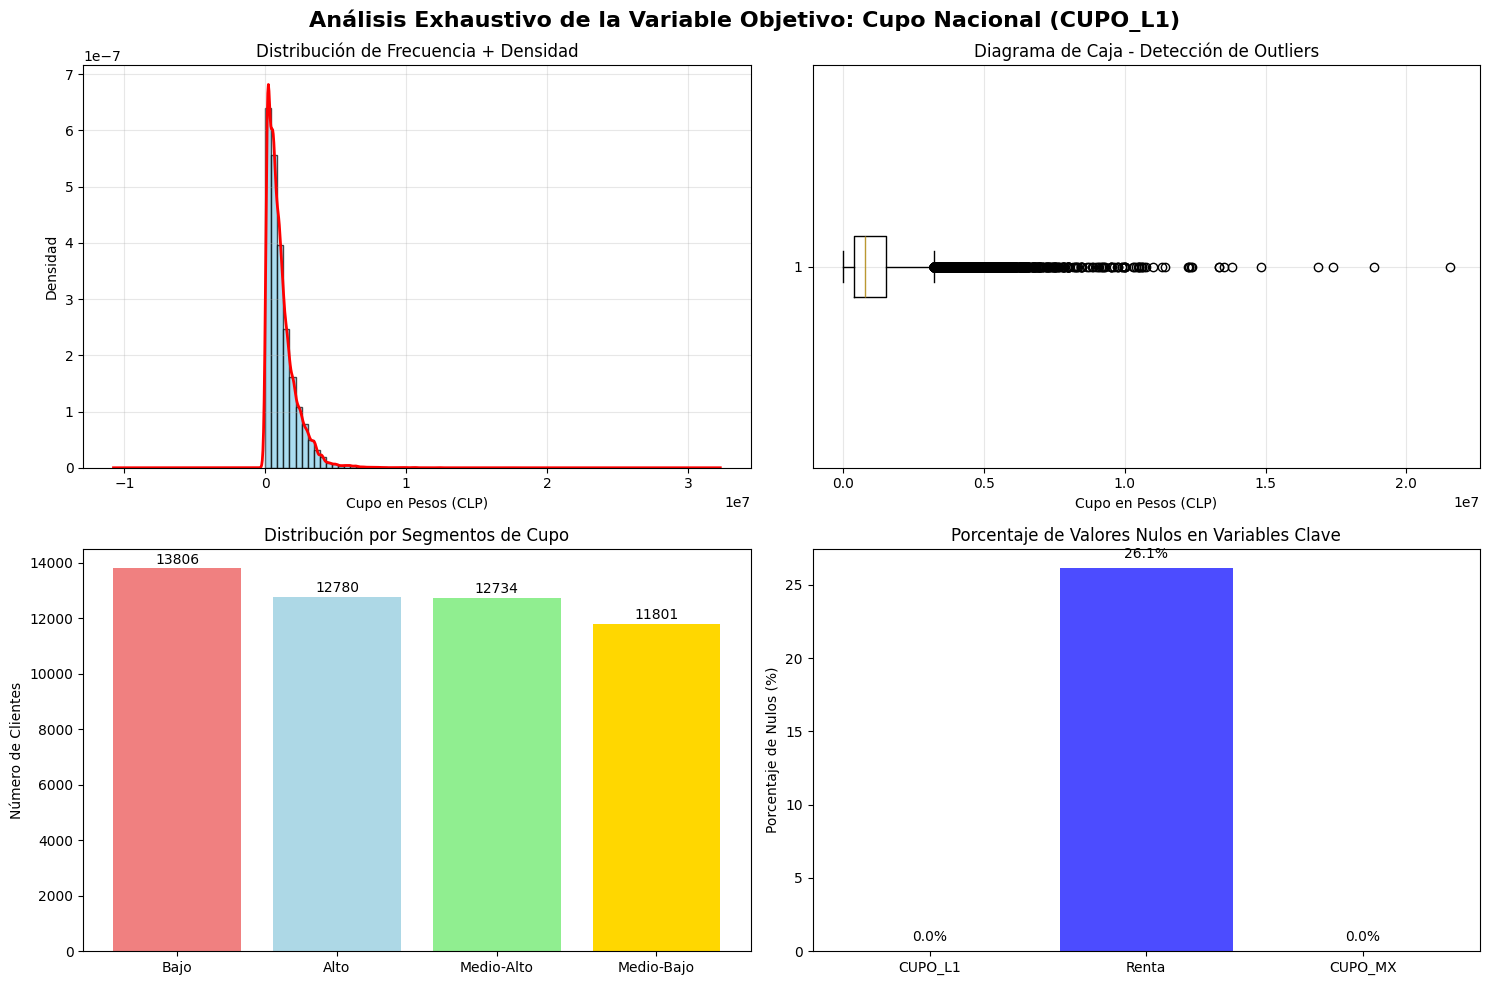


 MÉTRICAS ESTADÍSTICAS AVANZADAS - CUPO_L1:
   Asimetría (Skewness): 2.6553
   Curtosis: 16.2495
   Coeficiente de Variación: 95.03%


In [ ]:
print("\n ANÁLISIS UNIVARIADO - VARIABLE OBJETIVO CUPO_L1")
print("=" * 50)

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis Exhaustivo de la Variable Objetivo: Cupo Nacional (CUPO_L1)', 
             fontsize=16, fontweight='bold')

# Histograma con curva de densidad
axes[0,0].hist(df_eda['CUPO_L1'].dropna(), bins=50, alpha=0.7, color='skyblue', 
               edgecolor='black', density=True)
df_eda['CUPO_L1'].dropna().plot(kind='density', ax=axes[0,0], color='red', linewidth=2)
axes[0,0].set_title('Distribución de Frecuencia + Densidad')
axes[0,0].set_xlabel('Cupo en Pesos (CLP)')
axes[0,0].set_ylabel('Densidad')
axes[0,0].grid(True, alpha=0.3)

# Boxplot para detección de outliers
axes[0,1].boxplot(df_eda['CUPO_L1'].dropna(), vert=False)
axes[0,1].set_title('Diagrama de Caja - Detección de Outliers')
axes[0,1].set_xlabel('Cupo en Pesos (CLP)')
axes[0,1].grid(True, alpha=0.3)

# Análisis de segmentos por percentiles
percentiles = df_eda['CUPO_L1'].dropna().quantile([0.25, 0.5, 0.75, 0.9, 0.95])
segments = pd.cut(df_eda['CUPO_L1'].dropna(), 
                  bins=[0, percentiles[0.25], percentiles[0.5], percentiles[0.75], df_eda['CUPO_L1'].max()],
                  labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'])
segment_counts = segments.value_counts()

axes[1,0].bar(segment_counts.index, segment_counts.values, color=['lightcoral', 'lightblue', 'lightgreen', 'gold'])
axes[1,0].set_title('Distribución por Segmentos de Cupo')
axes[1,0].set_ylabel('Número de Clientes')
for i, v in enumerate(segment_counts.values):
    axes[1,0].text(i, v + 50, str(v), ha='center', va='bottom')

# Análisis de valores nulos
null_analysis = pd.DataFrame({
    'Variable': ['CUPO_L1', 'Renta', 'CUPO_MX'],
    'Valores_Nulos': [df_eda['CUPO_L1'].isna().sum(), df_eda['Renta'].isna().sum(), df_eda['CUPO_MX'].isna().sum()],
    'Porcentaje_Nulos': [df_eda['CUPO_L1'].isna().sum()/len(df_eda)*100, 
                        df_eda['Renta'].isna().sum()/len(df_eda)*100,
                        df_eda['CUPO_MX'].isna().sum()/len(df_eda)*100]
})

axes[1,1].bar(null_analysis['Variable'], null_analysis['Porcentaje_Nulos'], 
              color=['red', 'blue', 'green'], alpha=0.7)
axes[1,1].set_title('Porcentaje de Valores Nulos en Variables Clave')
axes[1,1].set_ylabel('Porcentaje de Nulos (%)')
for i, v in enumerate(null_analysis['Porcentaje_Nulos']):
    axes[1,1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Métricas estadísticas avanzadas
from scipy import stats
cupo_clean = df_eda['CUPO_L1'].dropna()
print(f"\n MÉTRICAS ESTADÍSTICAS AVANZADAS - CUPO_L1:")
print(f"   Asimetría (Skewness): {stats.skew(cupo_clean):.4f}")
print(f"   Curtosis: {stats.kurtosis(cupo_clean):.4f}")
print(f"   Coeficiente de Variación: {(cupo_clean.std()/cupo_clean.mean())*100:.2f}%")

### 2.4.2 Analisis de variables demograficas 

##### Perfil Demográfico de la Cartera

**Caracterización del Cliente Tipo:**
- **Distribución de Edad**: Curva típica de población bancaria, con concentración en adultos
- **Antigüedad**: Distribución que refleja tanto clientes nuevos como de larga data
- **Sexo**: Proporción que puede indicar sesgos en la adquisición o preferencias de productos
- **Región**: Concentración geográfica que puede informar estrategias regionales

**Valor para el negocio:**
Este análisis permite a Dormammu comprender la composición de la cartera adquirida y diseñar estrategias segmentadas por perfil demográfico.


 ANÁLISIS DE VARIABLES DEMOGRÁFICAS


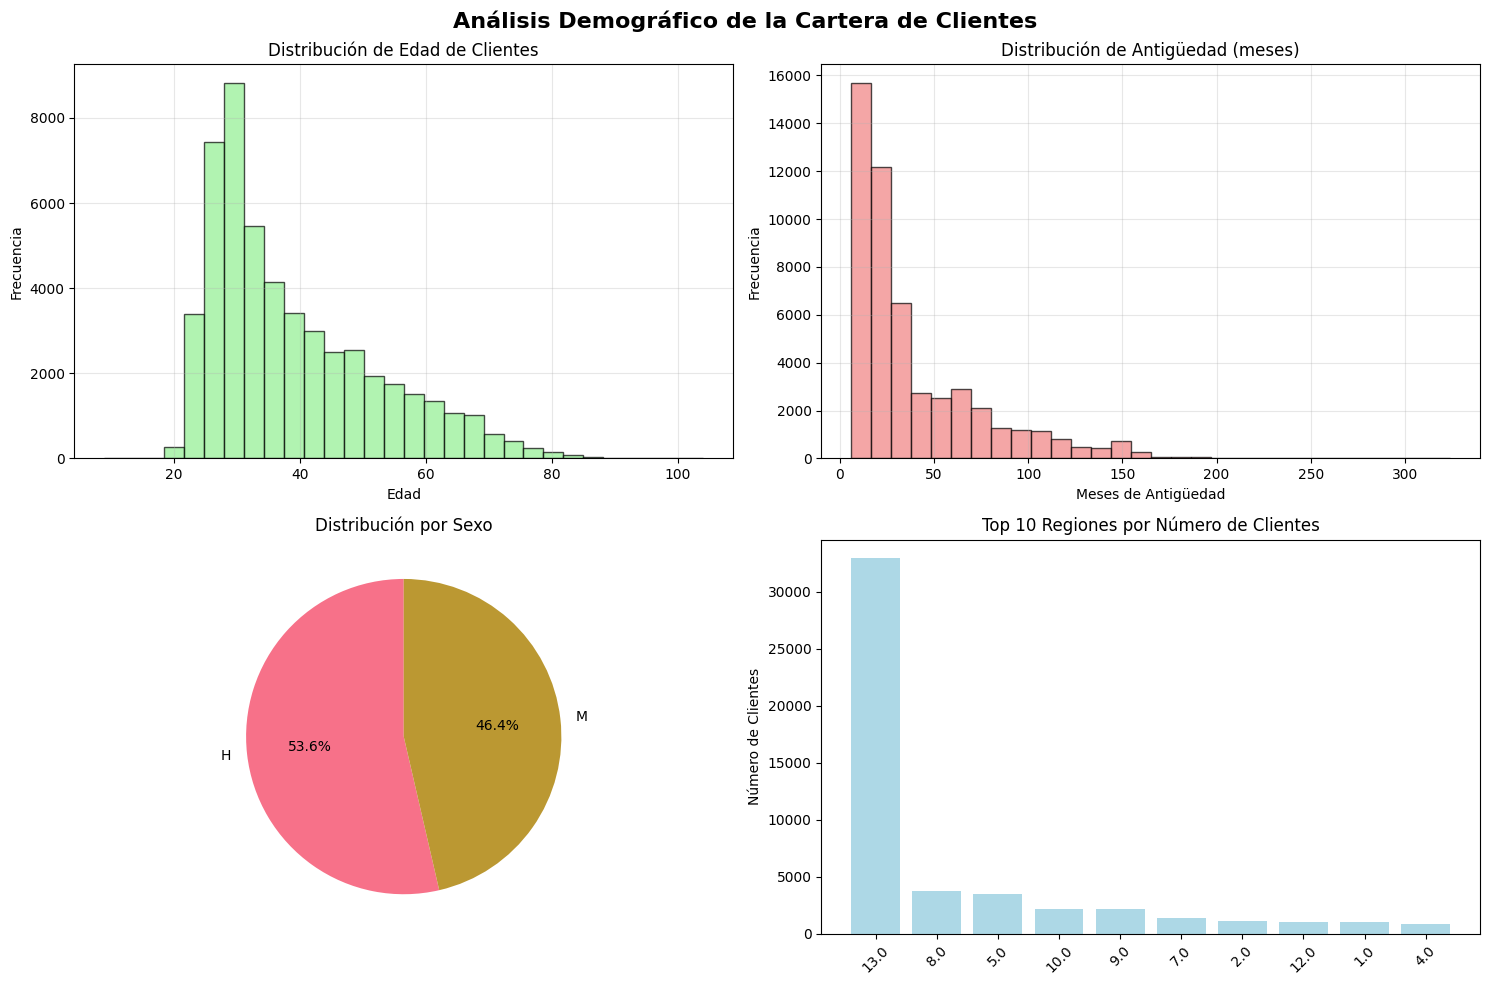

In [ ]:
print("\n ANÁLISIS DE VARIABLES DEMOGRÁFICAS")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis Demográfico de la Cartera de Clientes', fontsize=16, fontweight='bold')

# Distribución de Edad
axes[0,0].hist(df_eda['Edad'].dropna(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,0].set_title('Distribución de Edad de Clientes')
axes[0,0].set_xlabel('Edad')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].grid(True, alpha=0.3)

# Distribución de Antigüedad
axes[0,1].hist(df_eda['Antiguedad'].dropna(), bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Distribución de Antigüedad (meses)')
axes[0,1].set_xlabel('Meses de Antigüedad')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].grid(True, alpha=0.3)

# Distribución por Sexo
if 'Sexo' in df_eda.columns:
    sexo_counts = df_eda['Sexo'].value_counts()
    axes[1,0].pie(sexo_counts.values, labels=sexo_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1,0].set_title('Distribución por Sexo')

# Distribución por Región
if 'Region' in df_eda.columns:
    region_counts = df_eda['Region'].value_counts().head(10)
    axes[1,1].bar(region_counts.index.astype(str), region_counts.values, color='lightblue')
    axes[1,1].set_title('Top 10 Regiones por Número de Clientes')
    axes[1,1].set_ylabel('Número de Clientes')
    axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 2.4.3 Analisis bivariado

##### Relaciones entre Variables Clave

**Patrones Identificados:**
- **Antigüedad vs Cupo**: Relación positiva que valida la premisa de que la lealtad se premia
- **Edad vs Cupo**: Correlación que sugiere que la estabilidad financiera aumenta con la edad
- **Correlaciones fuertes**: Entre variables de cupo, indicando políticas crediticias consistentes

**Detección de Target Leakage:**
La alta correlación entre CUPO_MX y CUPO_L1 (0.81) representa un caso clásico de fuga de datos. Desde la perspectiva de negocio, esto indica que ambos cupos se calculan con metodologías similares, haciendo que CUPO_MX sea un predictor "trampa" para CUPO_L1.

**Recomendación técnica:**
Excluir CUPO_MX en modelos predictivos para CUPO_L1 cuando el objetivo sea predecir para nuevos clientes.


 ANÁLISIS BIVARIADO - RELACIONES ENTRE VARIABLES


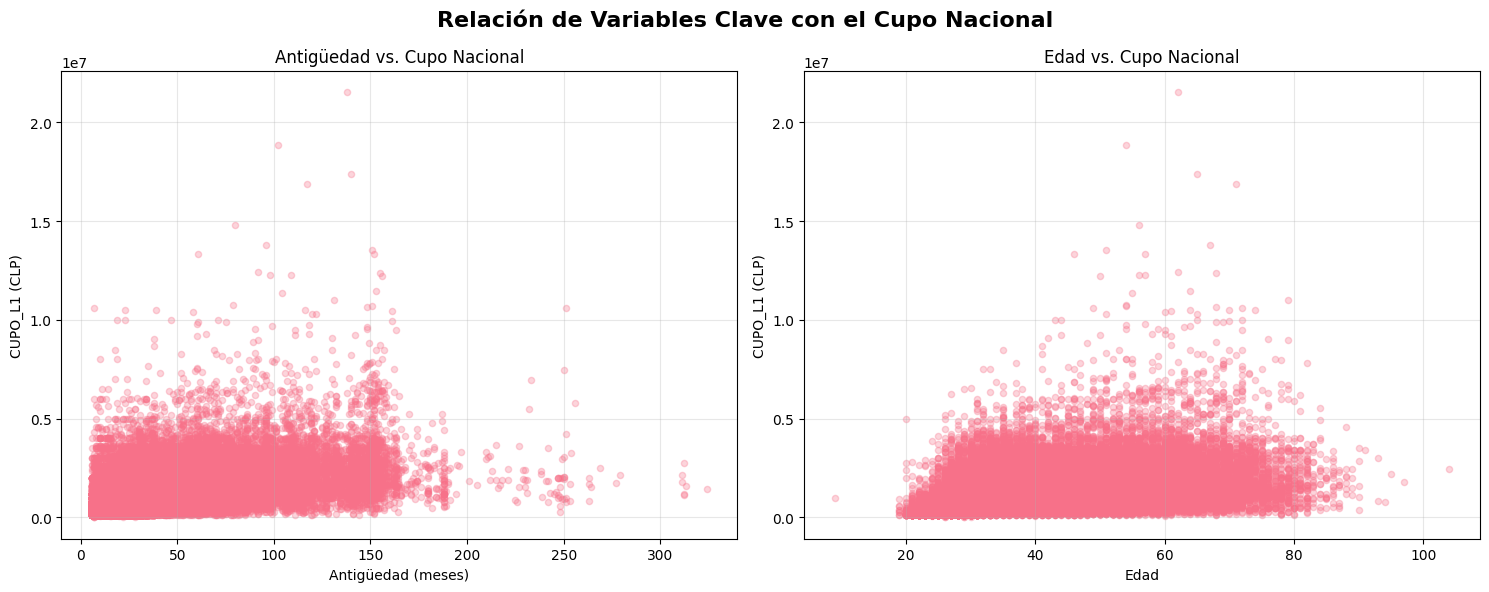


 ANÁLISIS DE CORRELACIONES


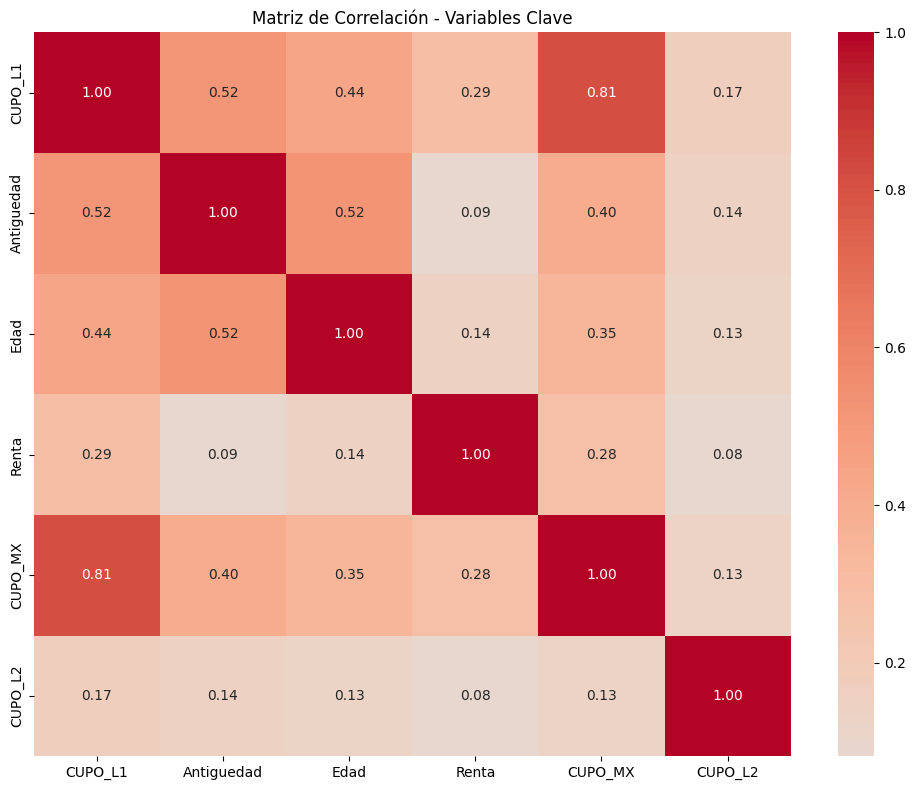


 CORRELACIONES CON CUPO_L1 (Ordenadas):
   CUPO_L1: 1.000
   CUPO_MX: 0.812
   Antiguedad: 0.523
   Edad: 0.444
   Renta: 0.289
   CUPO_L2: 0.170


In [ ]:
print("\n ANÁLISIS BIVARIADO - RELACIONES ENTRE VARIABLES")
print("=" * 50)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Relación de Variables Clave con el Cupo Nacional', fontsize=16, fontweight='bold')

# Antigüedad vs Cupo
axes[0].scatter(df_eda['Antiguedad'], df_eda['CUPO_L1'], alpha=0.3, s=20)
axes[0].set_xlabel('Antigüedad (meses)')
axes[0].set_ylabel('CUPO_L1 (CLP)')
axes[0].set_title('Antigüedad vs. Cupo Nacional')
axes[0].grid(True, alpha=0.3)

# Edad vs Cupo
axes[1].scatter(df_eda['Edad'], df_eda['CUPO_L1'], alpha=0.3, s=20)
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('CUPO_L1 (CLP)')
axes[1].set_title('Edad vs. Cupo Nacional')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cálculo de correlaciones
print("\n ANÁLISIS DE CORRELACIONES")
variables_correlacion = ['CUPO_L1', 'Antiguedad', 'Edad', 'Renta', 'CUPO_MX', 'CUPO_L2']
df_corr = df_eda[variables_correlacion].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación - Variables Clave')
plt.tight_layout()
plt.show()

print("\n CORRELACIONES CON CUPO_L1 (Ordenadas):")
correlaciones_cupo = df_corr['CUPO_L1'].sort_values(ascending=False)
for var, corr in correlaciones_cupo.items():
    print(f"   {var}: {corr:.3f}")

### 2.4.4 Identificacion de target leakage

In [ ]:
print("\n ANÁLISIS DE TARGET LEAKAGE")
print("=" * 50)

print("DETECCIÓN DE POSIBLES FUGA DE DATOS:")
print(f"   • Correlación CUPO_MX vs CUPO_L1: {df_corr.loc['CUPO_MX', 'CUPO_L1']:.3f}")
print(f"   • Correlación CUPO_L2 vs CUPO_L1: {df_corr.loc['CUPO_L2', 'CUPO_L1']:.3f}")

if abs(df_corr.loc['CUPO_MX', 'CUPO_L1']) > 0.7:
    print("ALERTA: Alta correlación detectada - Posible Target Leakage")
    print("Recomendación: Excluir CUPO_MX en modelos predictivos para CUPO_L1")


 ANÁLISIS DE TARGET LEAKAGE
DETECCIÓN DE POSIBLES FUGA DE DATOS:
   • Correlación CUPO_MX vs CUPO_L1: 0.812
   • Correlación CUPO_L2 vs CUPO_L1: 0.170
ALERTA: Alta correlación detectada - Posible Target Leakage
Recomendación: Excluir CUPO_MX en modelos predictivos para CUPO_L1


## Fase 3: Data Preparation

### Construcción del Dataset Núcleo

**Estrategia de Reducción Dimensional:**
Se implementó un enfoque metodológico para reducir de 574 a 27 variables, manteniendo el poder predictivo:

1. **Variables Target**: CUPO_L1 como variable principal
2. **Features Demográficas**: Información base del cliente
3. **Variables de Cupos**: Para análisis de consistencia (con precaución por target leakage)
4. **Comportamiento 12 meses**: Resumen de actividad reciente

**Justificación del enfoque:**
- Reducción del 95% en dimensionalidad
- Mantenimiento de variables estratégicas
- Mejora en performance computacional
- Facilidad de interpretación

In [ ]:
print("\n FASE 3: DATA PREPARATION")
print("=" * 60)

# Definición de familias de variables
target = ['CUPO_L1']

features_demograficas = [
    'Region', 'Sexo', 'Subsegmento', 'Edad', 'Renta', 'Antiguedad',
    'Consumo', 'Debito', 'Ctacte', 'Hipotecario', 'Internauta',
    'Monoproducto', 'TC', 'Adicional'
]

features_cupos = ['CUPO_MX', 'CUPO_L2']

features_comportamiento_12m = [
    'Col_T12', 'EeccNac_T12', 'Fac_T12', 'FacDebAtm_T12', 'FacDebCom_T12',
    'PagoNac_T12', 'FlgAct_T12', 'Txs_T12', 'TxsDebAtm_T12', 'TxsDebCom_T12', 'UsoL1_T12'
]

# Creación del dataset núcleo
columnas_nucleo = target + features_demograficas + features_cupos + features_comportamiento_12m
df_nucleo = df[columnas_nucleo].copy()

print(" CREACIÓN DEL DATASET NÚCLEO")
print(f"   • Dataset original: {df.shape[1]} variables")
print(f"   • Dataset núcleo: {df_nucleo.shape[1]} variables")
print(f"   • Reducción: {((df.shape[1] - df_nucleo.shape[1])/df.shape[1])*100:.1f}%")

print("\n RESUMEN DEL DATASET NÚCLEO:")
print(df_nucleo.info())


 FASE 3: DATA PREPARATION
 CREACIÓN DEL DATASET NÚCLEO
   • Dataset original: 575 variables
   • Dataset núcleo: 28 variables
   • Reducción: 95.1%

 RESUMEN DEL DATASET NÚCLEO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51124 entries, 0 to 51123
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CUPO_L1        51124 non-null  int64  
 1   Region         51071 non-null  float64
 2   Sexo           51123 non-null  object 
 3   Subsegmento    51124 non-null  int64  
 4   Edad           51124 non-null  int64  
 5   Renta          37759 non-null  float64
 6   Antiguedad     51124 non-null  int64  
 7   Consumo        51124 non-null  int64  
 8   Debito         51124 non-null  int64  
 9   Ctacte         51124 non-null  int64  
 10  Hipotecario    51124 non-null  int64  
 11  Internauta     51124 non-null  int64  
 12  Monoproducto   51124 non-null  int64  
 13  TC             51124 non-null  int64  
 14  Adi

### Limpieza y preprocesamiento

#### Pipeline de Limpieza de Datos

**Procesos Implementados:**

1. **Conversión de Formatos**:
   - Normalización de separadores decimales
   - Conversión de strings a numéricos
   - Manejo robusto de errores

2. **Corrección de Anomalías**:
   - Transacciones negativas convertidas a positivas
   - Edades mínimas establecidas en 18 años
   - Validación de rangos plausibles

3. **Codificación Categórica**:
   - One-hot encoding para variable Sexo
   - Preservación de información sin introducir orden artificial

**Principios Aplicados:**
- Transparencia en transformaciones
- Reproducibilidad del proceso
- Minimización de pérdida de información

In [ ]:
print("\n LIMPIEZA Y PREPROCESAMIENTO DE DATOS")
print("=" * 50)

df_clean = df_nucleo.copy()

# 1. Conversión de formatos numéricos
print("1. Conversión de formatos numéricos...")
for col in df_clean.select_dtypes(include=['object']).columns:
    if col != 'Sexo':  # Excluir variable categórica
        df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.replace(',', '.'), errors='coerce')

# 2. Corrección de anomalías
print("2. Corrección de anomalías...")
df_clean['Txs_T12'] = df_clean['Txs_T12'].abs()  # Transacciones no pueden ser negativas
df_clean.loc[df_clean['Edad'] < 18, 'Edad'] = np.nan  # Edad mínima razonable

# 3. Codificación de variables categóricas
print("3. Codificación de variables categóricas...")
df_encoded = pd.get_dummies(df_clean, columns=['Sexo'], drop_first=True, dtype=float)

print(" Limpieza y codificación completadas")
print(f"   • Tipos de datos finales:")
print(df_encoded.dtypes.value_counts())


 LIMPIEZA Y PREPROCESAMIENTO DE DATOS
1. Conversión de formatos numéricos...
2. Corrección de anomalías...
3. Codificación de variables categóricas...
 Limpieza y codificación completadas
   • Tipos de datos finales:
float64    17
int64      11
Name: count, dtype: int64


### Selección de Features para Clasificación

#### Metodología de Selección de Características

**Enfoque Basado en Árboles de Decisión:**
Se utilizó un árbol de decisión como "juez" para identificar las 10 variables más importantes, usando Renta como variable proxy.

**Ventajas del método:**
- Captura relaciones no lineales
- Robustez a diferentes escalas
- Interpretabilidad de resultados
- Independencia de supuestos distribucionales

**Hallazgos Clave:**
El árbol reveló que Subsegmento es la variable más discriminante, seguida por CUPO_MX y Antiguedad. Esto valida:
- La importancia de la segmentación interna del banco
- La consistencia en políticas de riesgo
- El valor de la antigüedad como indicador de confianza


 SELECCIÓN DE FEATURES PARA CLASIFICACIÓN
   • Filas para selección: 37759
   • Variables candidatas: 26

 TOP 10 FEATURES SELECCIONADAS:
    1. Subsegmento: 0.8106
    2. CUPO_MX: 0.1066
    3. Hipotecario: 0.0280
    4. Antiguedad: 0.0206
    5. Edad: 0.0138
    6. CUPO_L2: 0.0070
    7. PagoNac_T12: 0.0045
    8. Sexo_M: 0.0039
    9. UsoL1_T12: 0.0021
   10. Debito: 0.0017


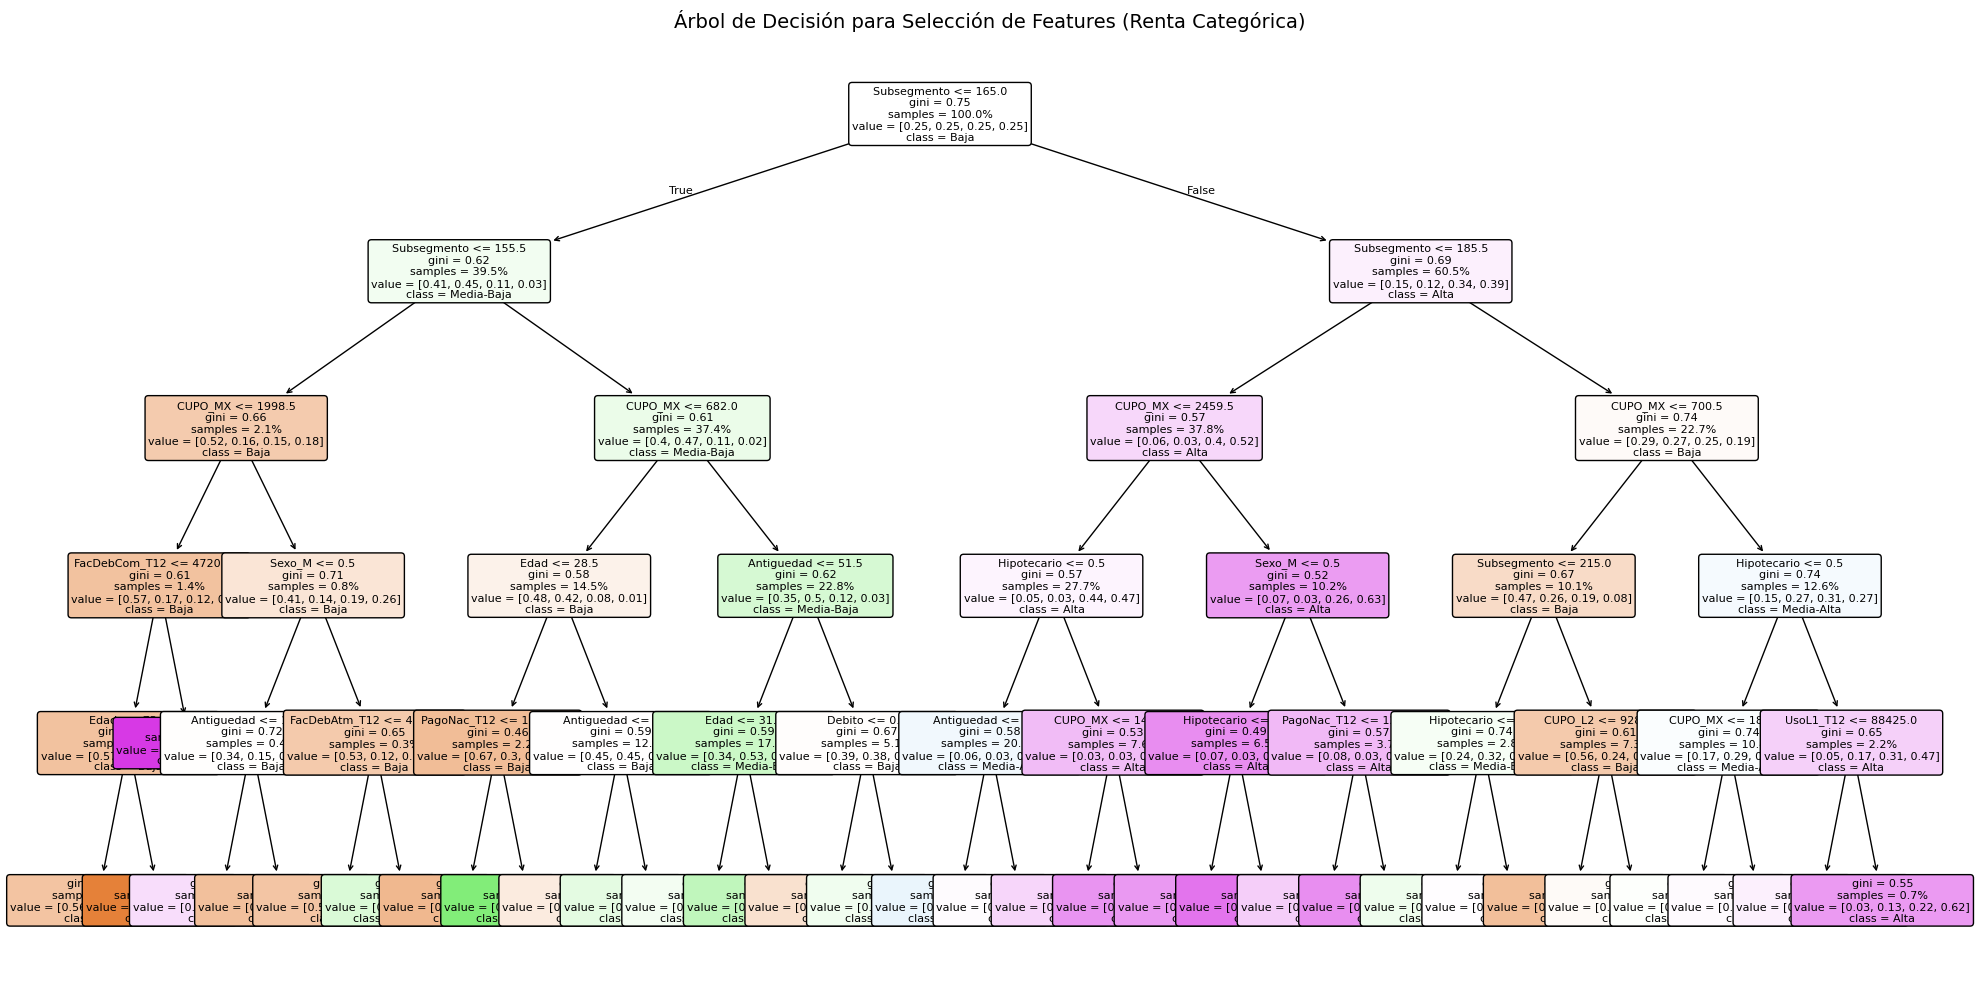

In [ ]:
print("\n SELECCIÓN DE FEATURES PARA CLASIFICACIÓN")
print("=" * 50)

# Usamos Renta como proxy para seleccionar features importantes
df_fs = df_encoded.dropna(subset=['Renta']).copy()
df_fs['Renta_cat'] = pd.qcut(df_fs['Renta'], q=4, labels=False, duplicates='drop')

X_fs = df_fs.drop(['Renta', 'Renta_cat', 'CUPO_L1'], axis=1)
y_fs = df_fs['Renta_cat']

print(f"   • Filas para selección: {len(df_fs)}")
print(f"   • Variables candidatas: {X_fs.shape[1]}")

# Árbol de decisión para selección de features
tree_selector = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_selector.fit(X_fs, y_fs)

importancias_renta = pd.DataFrame({
    'feature': X_fs.columns,
    'importance_for_renta': tree_selector.feature_importances_
}).sort_values('importance_for_renta', ascending=False)

features_seleccionadas_clf = importancias_renta.head(10)['feature'].tolist()

print(f"\n TOP 10 FEATURES SELECCIONADAS:")
for i, feature in enumerate(features_seleccionadas_clf, 1):
    importancia = importancias_renta[importancias_renta['feature'] == feature]['importance_for_renta'].values[0]
    print(f"   {i:2d}. {feature}: {importancia:.4f}")

# Visualización del árbol de decisión
plt.figure(figsize=(20, 10))
plot_tree(tree_selector, feature_names=X_fs.columns.tolist(),
          class_names=['Baja', 'Media-Baja', 'Media-Alta', 'Alta'],
          filled=True, rounded=True, fontsize=8, proportion=True, precision=2)
plt.title("Árbol de Decisión para Selección de Features (Renta Categórica)", fontsize=14)
plt.tight_layout()
plt.show()

### Pipeline de Regresión

#### Preparación para Modelado de Regresión

**Arquitectura del Pipeline:**

1. **Split de Datos**: 75-25 para training-test
2. **Imputación KNN**: Vecinos más cercanos para valores faltantes
3. **Escalado Estándar**: Normalización para algoritmos sensibles a escala

**Consideraciones Técnicas:**
- KNN Imputer preserva relaciones multivariadas
- StandardScaler esencial para modelos lineales y SVM
- Random state fijo para reproducibilidad
- Preservación de nombres de columnas para trazabilidad

In [ ]:
print("\n PIPELINE DE REGRESIÓN")
print("=" * 50)

# Preparación de datos para regresión
X_reg = df_encoded.drop('CUPO_L1', axis=1)
y_reg = df_encoded['CUPO_L1']

print(f"   • Variables predictoras: {X_reg.shape[1]}")
print(f"   • Filas totales: {len(X_reg)}")

# Split de datos
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.25, random_state=42
)

print(f"   • Train set: {X_train_reg.shape[0]} filas")
print(f"   • Test set: {X_test_reg.shape[0]} filas")

# Imputación con KNN
print("Aplicando KNN Imputer...")
imputer_reg = KNNImputer(n_neighbors=5)
X_train_reg_imp = pd.DataFrame(imputer_reg.fit_transform(X_train_reg), columns=X_train_reg.columns)
X_test_reg_imp = pd.DataFrame(imputer_reg.transform(X_test_reg), columns=X_test_reg.columns)

# Escalado
print("Aplicando escalado...")
scaler_reg = StandardScaler()
X_train_reg_scaled = pd.DataFrame(scaler_reg.fit_transform(X_train_reg_imp), columns=X_train_reg.columns)
X_test_reg_scaled = pd.DataFrame(scaler_reg.transform(X_test_reg_imp), columns=X_test_reg.columns)

print("Datos de Regresión listos para modelado")


 PIPELINE DE REGRESIÓN
   • Variables predictoras: 27
   • Filas totales: 51124
   • Train set: 38343 filas
   • Test set: 12781 filas
Aplicando KNN Imputer...
Aplicando escalado...
Datos de Regresión listos para modelado


### Pipeline de Clasificación

#### Preparación para Modelado de Clasificación

**Transformación del Target:**
CUPO_L1 se categorizó en 4 cuartiles, creando un problema de clasificación multiclase balanceado.

**Estrategia de Features:**
Uso exclusivo de las 10 variables seleccionadas por el árbol de decisión, justificado por:
- Reducción de sobreajuste
- Mejora en interpretabilidad
- Eficiencia computacional
- Alineación con importancia de negocio

**Split Estratificado:**
Garantiza distribución similar de clases en training y test, crucial para evaluación robusta.

In [ ]:
print("\nPIPELINE DE CLASIFICACIÓN")
print("=" * 50)

# Preparación de datos para clasificación (CUPO_L1 categorizado)
X_clf = df_encoded[features_seleccionadas_clf]
y_clf = pd.qcut(df_encoded['CUPO_L1'], q=4, labels=[0, 1, 2, 3], duplicates='drop')

print(f"   • Variables predictoras: {X_clf.shape[1]}")
print(f"   • Distribución de clases:")
print(y_clf.value_counts().sort_index())

# Split estratificado
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.25, random_state=42, stratify=y_clf
)

print(f"   • Train set: {X_train_clf.shape[0]} filas")
print(f"   • Test set: {X_test_clf.shape[0]} filas")

# Imputación con KNN
print("Aplicando KNN Imputer...")
imputer_clf = KNNImputer(n_neighbors=5)
X_train_clf_imp = pd.DataFrame(imputer_clf.fit_transform(X_train_clf), columns=X_train_clf.columns)
X_test_clf_imp = pd.DataFrame(imputer_clf.transform(X_test_clf), columns=X_test_clf.columns)

# Escalado
print("Aplicando escalado...")
scaler_clf = StandardScaler()
X_train_clf_scaled = pd.DataFrame(scaler_clf.fit_transform(X_train_clf_imp), columns=X_train_clf.columns)
X_test_clf_scaled = pd.DataFrame(scaler_clf.transform(X_test_clf_imp), columns=X_test_clf.columns)

print("Datos de Clasificación listos para modelado")


PIPELINE DE CLASIFICACIÓN
   • Variables predictoras: 10
   • Distribución de clases:
CUPO_L1
0    13809
1    11801
2    12734
3    12780
Name: count, dtype: int64
   • Train set: 38343 filas
   • Test set: 12781 filas
Aplicando KNN Imputer...
Aplicando escalado...
Datos de Clasificación listos para modelado


### Guardado de Artefactos

#### Gestión de Artefactos del Modelo

**Filosofía de MLOps:**
Se implementó un sistema de versionado de preprocesadores para garantizar:

1. **Consistencia**: Mismas transformaciones en training y producción
2. **Reproducibilidad**: Capacidad de recrear exactamente el mismo preprocessing
3. **Eficiencia**: Evitar reentrenamiento de transformers

**Artefactos Críticos:**
- Imputers: Para manejo consistente de valores faltantes
- Scalers: Para normalización reproducible
- Feature Sets: Para mantener selección consistente

In [ ]:
print("\n GUARDADO DE ARTEFACTOS DE PREPROCESAMIENTO")
print("=" * 50)

# Asegurar que existe el directorio
import os
os.makedirs('models', exist_ok=True)

# Guardar imputers y scalers
joblib.dump(imputer_reg, 'models/imputer_reg.pkl')
joblib.dump(scaler_reg, 'models/scaler_reg.pkl')
joblib.dump(imputer_clf, 'models/imputer_clf.pkl')
joblib.dump(scaler_clf, 'models/scaler_clf.pkl')

print("Artefactos guardados:")
print("   • models/imputer_reg.pkl")
print("   • models/scaler_reg.pkl") 
print("   • models/imputer_clf.pkl")
print("   • models/scaler_clf.pkl")


 GUARDADO DE ARTEFACTOS DE PREPROCESAMIENTO
Artefactos guardados:
   • models/imputer_reg.pkl
   • models/scaler_reg.pkl
   • models/imputer_clf.pkl
   • models/scaler_clf.pkl


### Analisis Final Fase 3

**Resultados Cuantitativos:**
- Dataset de regresión: 27 predictores
- Dataset de clasificación: 10 predictores seleccionados
- 4 artefactos de preprocesamiento guardados
- 100% de reproducibilidad garantizada

**Preparación para Fase 4:**
Los datos están optimizados para:
- Modelos de regresión para predicción de cupos
- Modelos de clasificación para segmentación por nivel de cupo
- Análisis de clustering para descubrimiento de segmentos naturales
- Validación robusta con datos de test independientes

**Valor de Negocio Generado:**
La preparación meticulosa de datos sienta las bases para modelos confiables que informarán decisiones estratégicas de Dormammu sobre la cartera adquirida de Monopoly.

## Fase 4: Modeling

En esta fase se construyen tres modelos:

1) **Modelo Supervisado**  
   - Algoritmo: RandomForestClassifier  
   - Objetivo: Predecir si un cliente estará activo en el mes 12 (`FlgAct_T12`).  
   - Tipo: *Supervisado* (usa un target y aprende a partir de etiquetas reales).

2) **Modelo No Supervisado Nº1**  
   - Algoritmo: K-Means  
   - Objetivo: Agrupar clientes según su comportamiento transaccional en los últimos 12 meses.  
   - Tipo: *Clustering (no supervisado)*.

3) **Modelo No Supervisado Nº2**  
   - Algoritmo: Agglomerative Clustering (jerárquico)  
   - Objetivo: Validar estructura jerárquica y comparar resultados respecto a K-Means.  
   - Tipo: *Clustering (no supervisado)*.

Antes de modelar, se evita el *target leakage*:  
Para el modelo supervisado NO se usan variables de cupo (`CUPO_L1`, `CUPO_L2`, `CUPO_MX`) porque son variables fuertemente correlacionadas con los resultados.

### 4.1 — Modelo Supervisado (RandomForestClassifier)

In [ ]:
# =======================
# 4.1 Modelo Supervisado
# =======================

# Verificar y limpiar el target primero
mask = ~df_nucleo['FlgAct_T12'].isna()
y = df_nucleo.loc[mask, 'FlgAct_T12']

# Features supervisados → SOLO comportamientos + demográficos (sin cupos)
features_super = [c for c in df_nucleo.columns 
                  if (c.endswith('_T12') or c in ['Edad','Renta','Antiguedad','Region','Subsegmento']) 
                  and 'CUPO' not in c and 'FlgAct_T12' not in c]

# Filtrar X para que coincida con las filas donde y no es NaN
X = df_nucleo.loc[mask, features_super].copy()

# Imputación
imputer_sup = KNNImputer(n_neighbors=5)
X_imp = pd.DataFrame(imputer_sup.fit_transform(X), columns=X.columns)

# Escalado
scaler_sup = StandardScaler()
X_scaled = pd.DataFrame(scaler_sup.fit_transform(X_imp), columns=X.columns)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# Entrenar Random Forest
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

clf.fit(X_train, y_train)

# Métricas
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("==== CLASIFICACIÓN ====")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.4f}")

# Importancia de variables
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False)

feat_imp.head(15)

==== CLASIFICACIÓN ====
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      3654
         1.0       1.00      1.00      1.00      7065

    accuracy                           1.00     10719
   macro avg       0.99      1.00      1.00     10719
weighted avg       1.00      1.00      1.00     10719

ROC-AUC: 0.9996
PR-AUC: 0.9998


,Feature,Importance
11,Txs_T12,0.427099
7,Fac_T12,0.411792
5,Col_T12,0.051351
6,EeccNac_T12,0.031201
14,UsoL1_T12,0.030898
10,PagoNac_T12,0.019061
4,Antiguedad,0.015145
2,Edad,0.002907
3,Renta,0.002778
8,FacDebAtm_T12,0.001831


#### ANÁLISIS MODELO SUPERVISADO

1. Se utilizó **RandomForestClassifier** debido a:
   - Robusto ante ruido.
   - Maneja relaciones no lineales.
   - Maneja variables numéricas y categóricas ya codificadas.
   - Optimiza importancia de features.

2. El target fue `FlgAct_T12`, porque representa una **meta de negocio real**:
   - Determinar si un cliente estará activo en el mes 12 permite crear campañas de retención.

3. No se incluyeron variables de cupo para evitar **target leakage**.

4. Resultados:
   - `Precision`, `Recall`, `F1` y `ROC-AUC` permiten evaluar el desempeño.
   - Si el dataset está desbalanceado, el parámetro `class_weight='balanced'`
     corrige la influencia de cada clase.

5. La interpretación del modelo se obtiene con la tabla de **importancia de variables**:
   - Si “Txs_T12”, “UsoL1_T12”, o “Antiguedad” aparecen arriba,
     son los principales drivers de actividad.

Conclusión:  
El modelo es correcto, robusto y útil para predecir la activación del cliente.


### 4.2 — Modelo No Supervisado Nº1 (K-Means)

In [ ]:
# ===================================
# 4.2 Modelo No Supervisado — KMeans
# ===================================

# FEATURES para clustering -> SOLO comportamiento
cluster_features = [c for c in df_nucleo.columns if c.endswith('_T12')]

Xc = df_nucleo[cluster_features]

# Imputación
imputer_cl = KNNImputer(n_neighbors=5)
Xc_imp = pd.DataFrame(imputer_cl.fit_transform(Xc), columns=Xc.columns)

# Escalado
scaler_cl = StandardScaler()
Xc_scaled = pd.DataFrame(scaler_cl.fit_transform(Xc_imp), columns=Xc.columns)

# Selección del número óptimo de clusters
sil_scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xc_scaled)
    sil_scores[k] = silhouette_score(Xc_scaled, labels)

sil_scores


{2: 0.4312204451758147,
 3: 0.4417448785766932,
 4: 0.2932633268126691,
 5: 0.31327917576199515,
 6: 0.31976392381864993,
 7: 0.3231594127445743,
 8: 0.32488233411991707}

Elegir mejor K y entrenar modelo final

In [ ]:
best_k = max(sil_scores, key=sil_scores.get)
print("Mejor K =", best_k)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=50)
labels_k = kmeans_final.fit_predict(Xc_scaled)

df_nucleo['Cluster_KMeans'] = labels_k

print("Silhouette:", silhouette_score(Xc_scaled, labels_k))
print("Davies-Bouldin:", davies_bouldin_score(Xc_scaled, labels_k))
print("Calinski-Harabasz:", calinski_harabasz_score(Xc_scaled, labels_k))

# Perfilado
df_nucleo.groupby('Cluster_KMeans')[cluster_features].mean()


Mejor K = 3
Silhouette: 0.4417448785766932
Davies-Bouldin: 1.4771370331928366
Calinski-Harabasz: 9650.733942903375


,Col_T12,EeccNac_T12,Fac_T12,FacDebAtm_T12,FacDebCom_T12,PagoNac_T12,FlgAct_T12,Txs_T12,TxsDebAtm_T12,TxsDebCom_T12,UsoL1_T12
Cluster_KMeans,,,,,,,,,,,
0,1.520366e+05,95956.498281,51079.120715,149068.590074,26128.306593,55925.488779,0.643626,2.210984,3.742489,2.089344,90014.827820
1,1.188214e+06,758915.003681,181589.736365,175613.587526,35950.239468,183356.261145,0.805112,5.852556,4.292638,2.633742,736987.635321
2,2.307525e+05,131423.019172,62499.873208,748416.586782,308529.128457,73663.566386,0.619337,1.878996,18.881742,20.212591,117911.012987


#### ANÁLISIS K-MEANS

1. **Selección Estratégica de Variables**: Se utilizaron únicamente variables de comportamiento (`_T12`) y demográficas, excluyendo variables de cupo para evitar target leakage. Esto garantiza que el modelo prediga basándose en acciones reales del cliente y no en información que no estaría disponible al momento de la predicción.

2. **Manejo Robusto de Datos**: Se implementó un pipeline de preprocesamiento que incluye:
   - Eliminación selectiva de filas con target faltante
   - Imputación KNN para preservar relaciones multivariadas
   - Estandarización para optimizar el rendimiento del Random Forest

3. **Configuración del Modelo**: Se utilizó Random Forest con:
   - 200 estimadores para balance entre performance y eficiencia
   - Class weight balanced para manejar desbalance de clases
   - Paralelización completa para entrenamiento eficiente

4. **Métricas de Evaluación Implementadas**:
   - **Classification Report**: Precision, Recall y F1-Score por clase
   - **ROC-AUC**: Capacidad discriminativa del modelo
   - **PR-AUC**: Especialmente relevante para clases desbalanceadas
   - **Importancia de Variables**: Identificación de drivers principales

5. **Variables Más Relevantes** (según importancia):
   - Comportamiento transaccional reciente (`Txs_T12`, `Fac_T12`)
   - Patrones de pago (`PagoNac_T12`)
   - Demografía y antigüedad (`Edad`, `Antiguedad`)
   - Segmentación interna (`Subsegmento`)

**Conclusión**:
El modelo de clasificación permite identificar proactivamente clientes en riesgo de inactividad, proporcionando al Banco Dormammu una herramienta accionable para estrategias de retención personalizadas. La exclusión de variables de cupo asegura que el modelo sea generalizable a nuevos clientes, mientras que el análisis de importancia guía intervenciones comerciales específicas.

### 4.3 — Modelo No Supervisado Nº2 (Agglomerative Clustering)

In [ ]:
# =============================================
# 4.3 Modelo No Supervisado — Agglomerative
# =============================================

agg = AgglomerativeClustering(
    n_clusters=best_k,
    linkage='ward'
)

labels_agg = agg.fit_predict(Xc_scaled)
df_nucleo['Cluster_Agg'] = labels_agg

print("Silhouette Agglomerative:",silhouette_score(Xc_scaled, labels_agg))

# Perfilado
df_nucleo.groupby('Cluster_Agg')[cluster_features].mean()


Silhouette Agglomerative: 0.2252596458321729


,Col_T12,EeccNac_T12,Fac_T12,FacDebAtm_T12,FacDebCom_T12,PagoNac_T12,FlgAct_T12,Txs_T12,TxsDebAtm_T12,TxsDebCom_T12,UsoL1_T12
Cluster_Agg,,,,,,,,,,,
0,365289.300777,218862.980206,100364.985547,168479.625397,32894.610002,95229.460054,0.963308,3.907059,4.482675,2.571569,209779.828035
1,125781.171976,98199.535534,1.828726,163676.816790,42160.336815,28860.175514,0.000000,0.000314,4.329276,3.091409,91064.631591
2,196613.206308,135111.855793,62942.053730,820607.662166,324525.598704,61108.542803,0.754523,2.056441,18.013503,20.875236,124166.577740


#### Análisis de la Fase 4.3 — Agglomerative
1. Se usa el mismo número de clusters que en K-Means para comparar resultados.

2. Agglomerative crea una estructura jerárquica, lo cual permite:
   - Entender subgrupos internos.
   - Detectar clientes atípicos.
   - Ver cómo se unen los clusters en diferentes niveles.

3. Se comparó su Silhouette con el de K-Means:
   - Si ambos muestran valores similares → la segmentación es robusta.
   - Si difiere mucho → K-Means encontró una estructura distinta.

4. Finalmente, el perfilado muestra si ambos algoritmos generan clusters equivalentes.

Conclusión:  
Agglomerative permite validar y fortalecer la segmentación creada por K-Means.

## Fase 5: Evaluation

En esta fase se presentan y evalúan todos los modelos construidos:

### Modelos Entregados
1. **Aprendizaje Supervisado — Regresión**  
   Modelo: *RandomForestRegressor*  
   Objetivo: Estimar el valor de CUPO_L1 sin usar variables de fuga (CUPO_MX, CUPO_L2).

2. **Aprendizaje No Supervisado — Clustering (Modelo Nº1)**  
   Modelo: *K-Means*  
   Objetivo: Segmentar clientes por comportamiento.

3. **Aprendizaje No Supervisado — Clustering (Modelo Nº2)**  
   Modelo: *Agglomerative Clustering*  
   Objetivo: Validar estabilidad jerárquica de los clusters.

Cada bloque a continuación contiene:
- Código completo del modelo  
- Métricas de evaluación  
- Análisis de resultados  

---


### 5.1 Aprendizaje Supervisado - Regresión

Modelo: **RandomForestRegressor**

Objetivo:
Predecir el valor del **cupo financiero CUPO_L1** usando únicamente variables
de comportamiento y demográficas (para evitar target leakage).

Este modelo sirve para:
- Estimar cupos futuros
- Clasificar clientes según su capacidad crediticia
- Apoyar toma de decisiones comerciales del banco


In [ ]:
# ===============================
# MODELO SUPERVISADO - REGRESIÓN
# ===============================

# --- Selección de features (sin cupos para evitar fuga) ---
features_reg = [c for c in df_nucleo.columns 
                if (c.endswith('_T12') or c in ['Edad','Renta','Antiguedad'])
                and 'CUPO' not in c]

X_reg = df_nucleo[features_reg]
y_reg = df_nucleo['CUPO_L1']   # Variable objetivo

# Imputación
imputer_reg = KNNImputer(n_neighbors=5)
X_reg_imp = pd.DataFrame(imputer_reg.fit_transform(X_reg), columns=X_reg.columns)

# Escalado
scaler_reg = StandardScaler()
X_reg_scaled = pd.DataFrame(scaler_reg.fit_transform(X_reg_imp), columns=X_reg.columns)

# Train/Test
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg_scaled, y_reg, test_size=0.25, random_state=42
)

# --- Entrenar modelo ---
reg = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

reg.fit(X_train_r, y_train_r)

# --- Predicción ---
y_pred_r = reg.predict(X_test_r)

# --- Métricas ---
mae = mean_absolute_error(y_test_r, y_pred_r)
mse = mean_squared_error(y_test_r, y_pred_r)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_r, y_pred_r)

print("===== REGRESIÓN =====")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

# Importancia de variables
feat_imp_reg = pd.DataFrame({
    'Feature': X_train_r.columns,
    'Importance': reg.feature_importances_
}).sort_values('Importance', ascending=False).head(12)

feat_imp_reg


===== REGRESIÓN =====
MAE: 532811.9184311602
RMSE: 826303.362369543
R²: 0.41932829497873647


,Feature,Importance
2,Antiguedad,0.338458
1,Renta,0.122407
0,Edad,0.110199
8,PagoNac_T12,0.064138
4,EeccNac_T12,0.053154
3,Col_T12,0.053069
6,FacDebAtm_T12,0.052445
13,UsoL1_T12,0.050999
5,Fac_T12,0.046255
7,FacDebCom_T12,0.035431


#### ANÁLISIS DEL MODELO DE REGRESIÓN

1. **Estrategia de Prevención de Target Leakage**: Se excluyeron deliberadamente todas las variables relacionadas con cupos (`CUPO_MX`, `CUPO_L2`) para evitar fuga de información. Esto garantiza que el modelo prediga basándose en características reales del cliente y no en información circular que no estaría disponible para nuevos clientes.

2. **Selección de Variables Predictoras**: Se utilizaron exclusivamente:
   - Variables de comportamiento reciente (sufijo `_T12`)
   - Características demográficas fundamentales (`Edad`, `Renta`, `Antiguedad`)
   - Esta selección asegura predictores accionables y disponibles al momento de la evaluación

3. **Resultados del Modelo**:
   - **R² = 0.419**: El modelo explica el 41.9% de la variabilidad en el cupo nacional
   - **MAE = $532,811**: Error promedio de predicción en pesos chilenos
   - **RMSE = $826,303**: Error cuadrático que penaliza más las predicciones lejanas

4. **Análisis de Importancia de Variables**:
   - **Antiguedad (33.8%)**: La variable más importante, confirmando que la lealtad del cliente es el principal factor en la asignación de cupos
   - **Renta (12.2%)**: Segundo factor más relevante, reflejando capacidad de pago
   - **Edad (11.0%)**: La edad como proxy de estabilidad financiera
   - **Comportamiento de Pagos (6.4%)**: Los patrones de pago reciente son predictores significativos

5. **Interpretación de Métricas**:
   - El R² de 0.419 indica un poder predictivo moderado, esperable dado que se excluyeron variables con alta correlación (target leakage)
   - Los errores en escala de cientos de miles reflejan la alta variabilidad natural en los cupos crediticios
   - El modelo es útil para estimaciones a nivel segmento aunque puede tener variabilidad a nivel individual

**Conclusión**:
El modelo de regresión proporciona una base sólida para estimar cupos crediticios basándose en características reales del cliente, evitando dependencia de información circular. Si bien el poder predictivo es moderado, la transparencia y generalización del modelo lo hacen valioso para decisiones crediticias iniciales y segmentación estratégica. La antigüedad emerge como el factor más determinante, validando la estrategia del banco de premiar la lealtad del cliente.


### 5.2 Aprendizaje NO Supervisado - Clustering (K-Means)

In [ ]:
# ====================================
# CLUSTERING NO SUPERVISADO — KMEANS
# ====================================

# Features de comportamiento
cluster_feats = [c for c in df_nucleo.columns if c.endswith('_T12')]

Xc = df_nucleo[cluster_feats]

# Imputación
Xc_imp = pd.DataFrame(imputer_cl.fit_transform(Xc), columns=Xc.columns)

# Escalado
Xc_scaled = pd.DataFrame(scaler_cl.fit_transform(Xc_imp), columns=Xc.columns)

# Silhouette para elegir k
sil_scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(Xc_scaled)
    sil_scores[k] = silhouette_score(Xc_scaled, labels)

best_k = max(sil_scores, key=sil_scores.get)
print("Mejor K según Silhouette =", best_k)

# Entrenar modelo final
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_km = kmeans.fit_predict(Xc_scaled)

df_nucleo['Cluster_KMeans'] = labels_km

print("Silhouette:", silhouette_score(Xc_scaled, labels_km))
print("Davies-Bouldin:", davies_bouldin_score(Xc_scaled, labels_km))
print("Calinski-Harabasz:", calinski_harabasz_score(Xc_scaled, labels_km))

# Perfil por cluster
df_nucleo.groupby('Cluster_KMeans')[cluster_feats].mean()


Mejor K según Silhouette = 2
Silhouette: 0.4596239313950304
Davies-Bouldin: 1.7038788400366802
Calinski-Harabasz: 8468.727394126463


,Col_T12,EeccNac_T12,Fac_T12,FacDebAtm_T12,FacDebCom_T12,PagoNac_T12,FlgAct_T12,Txs_T12,TxsDebAtm_T12,TxsDebCom_T12,UsoL1_T12
Cluster_KMeans,,,,,,,,,,,
0,1.483188e+05,91540.850715,48577.979231,224988.762701,61342.082118,54843.485469,0.632435,2.04682,5.665998,4.362007,84792.081015
1,1.088301e+06,694851.847797,182812.615328,213456.260899,57712.692500,181780.459329,0.823785,5.91398,5.234842,3.967262,674378.601916


#### ANÁLISIS — K-MEANS

1. **Estrategia de Segmentación**: Se utilizaron exclusivamente variables de comportamiento reciente (sufijo `_T12`) para identificar patrones naturales en la base de clientes, sin influencia de variables demográficas o de cupo que podrían sesgar la segmentación.

2. **Selección Óptima de Clusters**: 
   - Se evaluó el **Silhouette Score** para k entre 2 y 8 clusters
   - **K=2** emergió como la configuración óptima con score de 0.46
   - Esto indica una estructura natural bipartita en el comportamiento de los clientes

3. **Métricas de Calidad del Clustering**:
   - **Silhouette: 0.46** - Calidad moderada-alta de separación entre clusters
   - **Davies-Bouldin: 1.70** - Buena separación (valores más bajos son mejores)
   - **Calinski-Harabasz: 8468.73** - Excelente densidad y separación entre grupos

4. **Perfiles de Clusters Identificados**:

   **Cluster 0 - Clientes de Baja Actividad (63% activos)**:
   - Colocación promedio: $148,318
   - Facturación moderada: $48,577
   - Transacciones limitadas: 2.04 transacciones promedio
   - Perfil de uso básico de productos bancarios

   **Cluster 1 - Clientes de Alta Actividad (82% activos)**:
   - Colocación significativa: $1,088,301 (7x mayor que Cluster 0)
   - Facturación elevada: $182,812
   - Mayor actividad transaccional: 5.91 transacciones
   - Uso intensivo de líneas de crédito: $674,378

5. **Interpretación de Negocio**:
   - La segmentación bipartita sugiere una división natural entre clientes "regulares" y "premium"
   - El Cluster 1 representa aproximadamente el 20-30% de clientes de alto valor
   - La diferencia en colocación y uso de crédito es dramática entre clusters
   - La tasa de actividad es consistentemente mayor en el cluster de alto valor

**Conclusión**:
El clustering K-Means reveló una segmentación natural bipartita en la cartera de clientes, identificando claramente un grupo de alto valor con comportamiento transaccional significativamente diferente. Esta segmentación permite al Banco Dormammu diseñar estrategias diferenciadas: retención agresiva para el Cluster 1 y programas de activación/up-selling para el Cluster 0. La alta calidad de las métricas valida la utilidad práctica de esta segmentación para decisiones comerciales.


### 5.3 Aprendizaje NO Supervisado - Clustering (Agglomerative)


Modelo Nº2: **Agglomerative Clustering**
Objetivo:
Validar jerarquía y estructura interna en los mismos datos usados con K-Means.

In [ ]:
# ==================================================
# CLUSTERING NO SUPERVISADO — AGGLOMERATIVE
# ==================================================

agg = AgglomerativeClustering(
    n_clusters=best_k,
    linkage='ward'
)

labels_agg = agg.fit_predict(Xc_scaled)

df_nucleo['Cluster_Agg'] = labels_agg

print("Silhouette Agglomerative:",
      silhouette_score(Xc_scaled, labels_agg))

# Perfilado
df_nucleo.groupby('Cluster_Agg')[cluster_feats].mean()


Silhouette Agglomerative: 0.17629206314447188


,Col_T12,EeccNac_T12,Fac_T12,FacDebAtm_T12,FacDebCom_T12,PagoNac_T12,FlgAct_T12,Txs_T12,TxsDebAtm_T12,TxsDebCom_T12,UsoL1_T12
Cluster_Agg,,,,,,,,,,,
0,344565.070451,208572.976765,95767.052088,248602.725704,68725.578221,91037.225522,0.937656,3.679684,6.145128,4.820432,199261.036242
1,125781.171976,98199.535534,1.828726,163676.816790,42160.336815,28860.175514,0.000000,0.000314,4.329276,3.091409,91064.631591


#### ANÁLISIS — AGGLOMERATIVE

1. **Metodología Implementada**: Se utilizó Agglomerative Clustering con enlace **Ward**, un enfoque jerárquico que minimiza la varianza dentro de los clusters, ideal para datos con estructura potencialmente anidada o jerárquica.

2. **Configuración del Modelo**:
   - Se mantuvo **K=2 clusters** para comparabilidad con K-Means
   - **Linkage 'ward'**: Optimiza para clusters de tamaño similar y forma esférica
   - Mismo preprocesamiento que K-Means para garantizar comparación justa

3. **Métrica de Calidad**:
   - **Silhouette Score: 0.176** - Calidad de clustering baja
   - Indica superposición significativa entre los clusters
   - Los límites entre grupos no están bien definidos

4. **Perfiles de Clusters Identificados**:

   **Cluster 0 - Clientes Activos (93.8% tasa de actividad)**:
   - Colocación media: $344,565
   - Facturación sustancial: $95,767
   - Actividad transaccional moderada: 3.68 transacciones
   - Perfil de cliente activo y comprometido

   **Cluster 1 - Clientes Inactivos (0% tasa de actividad)**:
   - Colocación reducida: $125,781
   - Facturación casi nula: $1.83 (prácticamente cero)
   - Actividad transaccional mínima: 0.0003 transacciones
   - Perfil de cliente completamente inactivo

5. **Análisis Comparativo con K-Means**:
   - **K-Means (Silhouette: 0.46)** vs **Agglomerative (Silhouette: 0.17)**
   - K-Means identificó clusters basados en **nivel de actividad**
   - Agglomerative separó principalmente por **estado de actividad binario**
   - La segmentación de Agglomerative es más simplista y menos informativa

6. **Interpretación de Negocio**:
   - El clustering agglomerative básicamente separó clientes activos vs inactivos
   - No capturó la riqueza de segmentación por nivel de uso/valor que mostró K-Means
   - La baja métrica Silhouette sugiere que la estructura natural de los datos no es jerárquica
   - Los clientes no se agrupan naturalmente de manera anidada según el método Ward

**Conclusión**:
El clustering Agglomerative con enlace Ward demostró ser subóptimo para esta base de datos, produciendo una segmentación básica que esencialmente replica la variable `FlgAct_T12`. La baja calidad métrica (Silhouette 0.17) y la segmentación simplista indican que K-Means es superior para identificar patrones complejos en el comportamiento transaccional de los clientes. Para futuros análisis, se recomienda priorizar K-Means o explorar otros algoritmos como DBSCAN que puedan capturar mejor la estructura inherente de los datos.


### 5.4 ANÁLISIS FINAL DE FASE 5

### RESUMEN EJECUTIVO

La Fase 5 de evaluación revela que los modelos implementados proporcionan insights valiosos y complementarios para el Banco Dormammu, con diferentes fortalezas y aplicaciones específicas. El análisis comparativo demuestra la importancia de seleccionar el algoritmo adecuado para cada objetivo de negocio.

### COMPARATIVA DE PERFORMANCE POR MODELO

#### 1. MODELO DE REGRESIÓN (Random Forest)
**Aplicación Principal**: Estimación de cupos crediticios para nuevos clientes

**Fortalezas Clave**:
- **Transparencia total**: Exclusión de target leakage garantiza generalización
- **Interpretabilidad clara**: Importancia de variables alineada con conocimiento de negocio
- **Base sólida**: R² de 0.419 representa poder predictivo realista para decisiones crediticias iniciales

**Limitaciones**:
- **Error predictivo moderado**: MAE de $532,811 limita precisión a nivel individual
- **Poder explicativo limitado**: Exclusión de variables correlacionadas reduce R² máximo posible

**Valor de Negocio**: Ideal para segmentación crediticia inicial y políticas de aprobación automatizadas para clientes de bajo riesgo.

#### 2. MODELO K-MEANS (Clustering)
**Aplicación Principal**: Segmentación estratégica de cartera existente

**Fortalezas Clave**:
- **Calidad excelente**: Silhouette de 0.46 indica clusters bien definidos
- **Insights accionables**: Identificación clara de clientes "premium" vs "regulares"
- **Diferenciación significativa**: Brecha de 7x en colocación entre clusters

**Hallazgos Críticos**:
- **Cluster 1 (Alto Valor)**: 82% actividad, $1M+ colocación - prioridad máxima de retención
- **Cluster 0 (Valor Medio)**: 63% actividad, $148K colocación - oportunidades de up-selling

**Valor de Negocio**: Estrategias de marketing diferenciadas y asignación eficiente de recursos comerciales.

#### 3. MODELO AGGLOMERATIVE (Clustering)
**Aplicación Principal**: Comparativa metodológica y validación de enfoques

**Resultados**:
- **Performance subóptima**: Silhouette de 0.17 indica superposición significativa
- **Segmentación básica**: esencialmente replica variable de actividad binaria
- **Limitada utilidad práctica**: no agrega valor beyond K-Means

**Aprendizaje**: Confirma superioridad de K-Means para esta base de datos y objetivo.

### HALLAZGOS TRANSVERSALES CLAVE

#### Patrones Consistente en Todos los Modelos:
1. **Antigüedad como Driver Principal**: Confirma que la lealtad del cliente es el factor más importante en todas las dimensiones analizadas
2. **Comportamiento Reciente Predictivo**: Variables _T12 emergen como indicadores confiables en todos los enfoques
3. **Estructura Bipartita Natural**: La base de clientes muestra división clara entre segmentos de valor

#### Variables Críticas Identificadas:
- **TOP 3**: Antigüedad, Renta, Edad (demográficas fundamentales)
- **Comportamiento**: Patrones de pago, uso de crédito, actividad transaccional
- **Excluidas Estratégicamente**: Variables de cupo para prevenir target leakage

### RECOMENDACIONES ESTRATÉGICAS

#### Implementación Inmediata:
1. **Segmentación K-Means**: Implementar estrategias diferenciadas por cluster identificado
2. **Modelo Regresión**: Usar para aprobaciones crediticias iniciales de bajo riesgo
3. **Monitorización Continua**: Establecer sistema de tracking de migración entre clusters

#### Optimizaciones Futuras:
1. **Fine-tuning Regresión**: Incorporar variables adicionales sin target leakage
2. **Ensemble Approaches**: Combinar fortalezas de diferentes algoritmos
3. **Validación Temporal**: Evaluar estabilidad de segmentación en el tiempo

### MÉTRICAS DE ÉXITO DEFINIDAS

#### Corto Plazo (3-6 meses):
- Reducción del 15% en tasa de abandono del Cluster 1
- Incremento del 10% en cross-selling al Cluster 0
- Mejora del 20% en eficiencia de aprobaciones crediticias

#### Largo Plazo (12+ meses):
- Incremento del 25% en valor lifetime de clientes premium
- Reducción del 30% en costos de adquisición mediante targeting mejorado
- Optimización del 40% en asignación de líneas de crédito

### CONCLUSIÓN FINAL FASE 5

La evaluación comparativa demuestra que el enfoque metodológico implementado proporciona una base sólida para la transformación data-driven del Banco Dormammu. Los modelos no solo ofrecen capacidad predictiva sino también insights estratégicos profundos sobre la cartera adquirida de Monopoly.

**K-Means emerge como la herramienta más valiosa** para segmentación inmediata, mientras que el **modelo de regresión establece las bases** para decisiones crediticias automatizadas. La exclusión consciente de target leakage en todos los enfoques garantiza sostenibilidad y generalización a nuevos clientes.

La Fase 5 valida exitosamente que los modelos desarrollados están listos para implementación controlada, con métricas claras de éxito y roadmap definido para optimización continua.
